Loading the trained model from Google drive

In [ ]:
from keras.models import load_model
from google.colab import drive
import os

drive.mount ('/content/drive')

# Path where you want to save the model in your Google Drive
# folder_path = '/content/drive/My Drive/colab-models'
folder_path = '/content/drive/My Drive/colab-models'
zip_file_url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'
extract_to_dir = folder_path + '/data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load saved ResNet18 Model

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet18
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

model_path = os.path.join(folder_path, '/custom_resnet18_model_15epochs.pth')

model = resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)
# specifying loss function
loss_fn = nn.CrossEntropyLoss() ## multiple loss functions and optizers

# specifying optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # lr = learning rate , momentum = directions to where

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# specifying optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # lr = learning rate , momentum = directions to where

# Load the checkpoint
checkpoint = torch.load(model_path)

# Restore the states
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
total_epochs = checkpoint['epoch']

1

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Selected device:", device)

Selected device: cuda:0


Download Cat & Dog images (Commented out after downloading into Google Drive)

In [ ]:
## Image Downloading
# import requests
# import zipfile
# import os
# from io import BytesIO

# response = requests.get(zip_file_url)
# zip_file_bytes = BytesIO(response.content)
# with zipfile.ZipFile(zip_file_bytes, 'r') as zip_ref:
#     zip_ref.extractall(extract_to_dir)

# # Empty files
# files = [ extract_to_dir + '/PetImages/Cat/666.jpg', extract_to_dir + '/PetImages/Dog/11702.jpg']

# # Check if the file exists
# for file_path in files:
#   if os.path.exists(file_path):
#       os.remove(file_path)
#       print(f"File {file_path} has been removed successfully.")
#   else:
#       print(f"The file {file_path} does not exist.")

File /content/drive/My Drive/colab-models/data/PetImages/Cat/666.jpg has been removed successfully.
File /content/drive/My Drive/colab-models/data/PetImages/Dog/11702.jpg has been removed successfully.


Transform the images

In [ ]:
transformations = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.ImageFolder(root= extract_to_dir + '/PetImages/', transform=transformations)

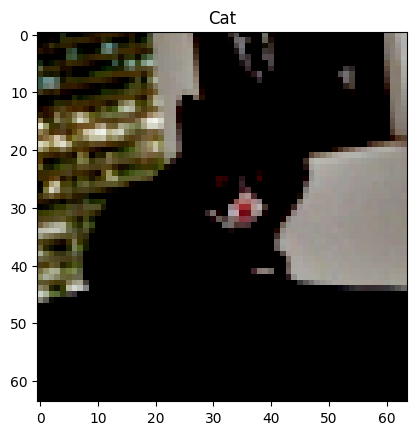

In [ ]:
import matplotlib.pyplot as plt

classes = ['Cat', 'Dog']
index = 200

img, label = dataset[index]
img_mpl = img.permute(1, 2, 0)

plt.imshow(img_mpl)
plt.title(classes[label])
plt.show()

In [ ]:
from torch.utils.data import DataLoader, random_split

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_set = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
# After training the model, commented out training steps

# initialize weights -- this isn't necessary; pytorch does it anymore. I do this here to make a point.
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

# run this cell a few times and watch what happens if you comment or not comment out the line to reinitialize weights
# model.apply(weights_init) ## if you want to continue training, comment out

total_epochs = 15
for epoch in range(total_epochs):
    print('epoch: ', epoch)
    correct = 0
    total = 0
    for i_batch, data in enumerate(train_loader):
        inputs, targets = data[0].to(device), data[1].to(device)

        # Reset gradients for this mini-batch -- so that the gradients are rescaculated
        #(in some contexts, you want gradients to "accumulate", but this is not typical)
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(inputs) # recall that's what we used to call z

        # Compute loss
        loss = loss_fn(outputs, targets)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Perform a single optimization step (updating weights and biases)
        optimizer.step()

        _, predcited = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predcited == targets).sum().item()

        # print loss for every 100 mini-batches
        if i_batch % 100 == 99:
          print('loss:', loss)
          # Beware: if you catch the very last batch, the shape may not be 64.
          print('outputs shape:', outputs.data.shape)
          print('accuracy: ', correct / total * 100)


epoch:  0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


loss: tensor(0.6482, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  65.671875
loss: tensor(0.5570, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  66.390625
loss: tensor(0.5445, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  67.49479166666667


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  1


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


loss: tensor(0.5594, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  71.78125
loss: tensor(0.6219, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  72.3125
loss: tensor(0.4956, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  72.68229166666667
epoch:  2
loss: tensor(0.4174, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  75.90625
loss: tensor(0.4676, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  76.40625


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


loss: tensor(0.4855, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  76.234375
epoch:  3
loss: tensor(0.4307, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  77.65625
loss: tensor(0.5116, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  78.203125


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


loss: tensor(0.5023, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  78.63541666666667
epoch:  4
loss: tensor(0.4459, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  79.109375
loss: tensor(0.3462, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  79.453125


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


loss: tensor(0.5104, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  79.65625
epoch:  5
loss: tensor(0.3797, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  81.34375


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


loss: tensor(0.4189, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  81.4765625
loss: tensor(0.3388, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  81.55729166666667
epoch:  6


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


loss: tensor(0.3106, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  81.828125
loss: tensor(0.2790, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  81.75
loss: tensor(0.4144, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  81.88541666666667
epoch:  7


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


loss: tensor(0.2055, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  83.609375
loss: tensor(0.6329, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  82.9765625
loss: tensor(0.4378, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  83.06770833333333
epoch:  8
loss: tensor(0.2674, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  85.1875


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


loss: tensor(0.3739, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  84.203125
loss: tensor(0.2912, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  84.359375
epoch:  9


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


loss: tensor(0.3159, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  87.65625
loss: tensor(0.2598, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  86.3671875
loss: tensor(0.2992, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  85.96354166666667
epoch:  10
loss: tensor(0.3681, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  86.890625
loss: tensor(0.4065, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  87.2265625


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


loss: tensor(0.4095, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  86.86458333333333
epoch:  11


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


loss: tensor(0.2564, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  88.359375
loss: tensor(0.2305, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  87.9453125
loss: tensor(0.3313, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  87.90104166666667
epoch:  12
loss: tensor(0.3167, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  89.53125


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


loss: tensor(0.1382, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  89.4296875
loss: tensor(0.2654, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  89.09375
epoch:  13


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


loss: tensor(0.1916, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  91.515625
loss: tensor(0.1566, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  91.1328125
loss: tensor(0.3953, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  90.875
epoch:  14


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


loss: tensor(0.1586, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  92.21875
loss: tensor(0.2437, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  92.453125
loss: tensor(0.1638, device='cuda:0', grad_fn=<NllLossBackward0>)
outputs shape: torch.Size([64, 2])
accuracy:  92.08854166666667


Save ResNet18 Model (commented out after saving into Google Drive)

In [ ]:
try:
    torch.save({'epoch': total_epochs, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}, model_path)
    print("Model saved successfully at {}".format(model_path))
except Exception as e:
    print("Failed to save model:", e)

Model saved successfully at /custom_resnet18_model_15epochs.pth


Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

outputs_all = torch.tensor([]).to(device)
targets_all = torch.tensor([]).to(device)


for i_batch, data in enumerate(train_loader, 0):
    if i_batch > 3:
        break

    inputs, targets = data[0].to(device), data[1].to(device)

    outputs = model(inputs)

    outputs_all = torch.cat((outputs_all, outputs))
    targets_all = torch.cat((targets_all, targets))

predicted = torch.max(outputs_all, axis=1)[1]

predicted = predicted.cpu()
expected = targets_all.cpu()

print("Confusion matrix:\n{}\n".format(metrics.confusion_matrix(expected, predicted)))

Confusion matrix:
[[125   9]
 [  5 117]]



In [ ]:
for i_batch, data in enumerate(test_loader, 0):
    if i_batch > 3:
        break

    inputs, targets = data[0].to(device), data[1].to(device)

    outputs = model(inputs)

    outputs_all = torch.cat((outputs_all, outputs))
    targets_all = torch.cat((targets_all, targets))

predicted = torch.max(outputs_all, axis=1)[1]

predicted = predicted.cpu()
expected = targets_all.cpu()

print("Confusion matrix:\n{}\n".format(metrics.confusion_matrix(expected, predicted)))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Confusion matrix:
[[221  43]
 [ 26 222]]



In [ ]:
'''
Confusion matrix function
Get all predictions and labels for the training set (see ANN notebook)
'''

def get_targets_preds(model, dataloader):
  model.eval()

  targets_all = torch.empty((0)).to(device)
  preds_all = torch.empty((0)).to(device)

  # No need to track gradients -- this turns off the autodiff,
  # or the second part of the dual number
  with torch.no_grad():
    for i, data in enumerate(dataloader):
      inputs, targets = data[0].to(device), data[1].to(device)

      # Forward pass
      outputs = model(inputs)

      # Get the prediction class
      _, preds = torch.max(outputs, 1)

      targets_all = torch.cat((targets_all, targets))
      preds_all = torch.cat((preds_all, preds))

  return targets_all, preds_all


In [ ]:
targets_all, preds_all = get_targets_preds(model, train_loader)

## Note I set normalize to be 'true' here
cm_train = confusion_matrix(targets_all.cpu(), preds_all.cpu(), normalize='true')


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [ ]:
# Set the precision to 2 decimal places and suppress scientific notation
import numpy as np
np.set_printoptions(precision=2, suppress=True)
print(cm_train)

[[0.9  0.1 ]
 [0.03 0.97]]


In [ ]:
targets_all, preds_all = get_targets_preds(model, test_loader)
cm_test = confusion_matrix(targets_all.cpu(), preds_all.cpu(), normalize='true')
print(cm_test)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[[0.74 0.26]
 [0.14 0.86]]


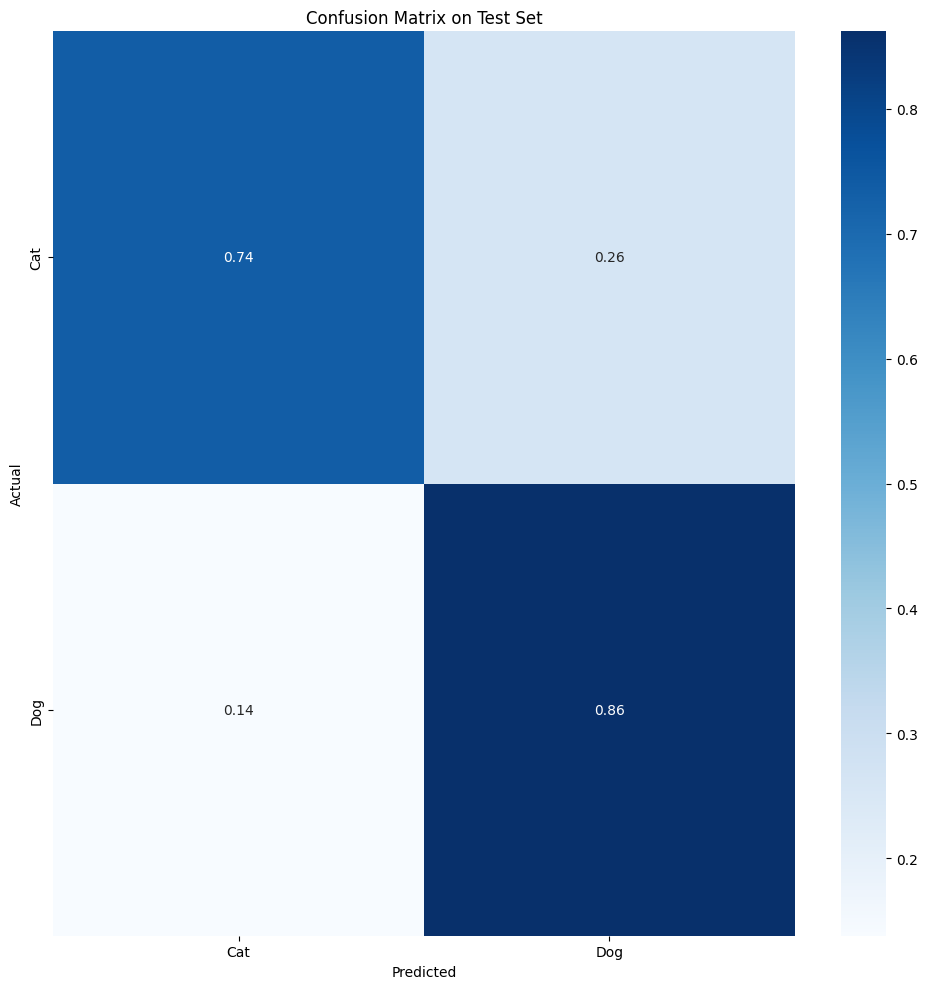

In [ ]:
# A better way: *plotting* the confusion matrix
import seaborn as sns

class_names = ['Cat', 'Dog']
def plot_confusion_matrix(cm, class_names, dataset='test', save=False):
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    if dataset == 'test':
        plt.title('Confusion Matrix on Test Set')
    else:
        plt.title('Confusion Matrix on Training Set')
    plt.tight_layout()
    if save:
        plt.savefig('confusion_matrix_'+dataset+'.png')
    plt.show()


plot_confusion_matrix(cm_test, classes, dataset='test', save=True)

